In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from IPython.core.display import display, HTML

In [2]:
def read_data(files, path):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if 'received message: Node/Block' in line or 'received message: Node/Sync' in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:%S.%f')
    return df

In [4]:
def aggregate(df, time):
    agg = df.groupby([pd.Grouper(freq= str(time) + 'Min', key = 'time'), 'message'])['message'].count().\
    reset_index(name = 'count')
    return agg

In [5]:
def draw_graph(df, alert, time):
    
    df = df.sort_values(by='time').reset_index(drop = True)
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "") + "message.html"
    png_path = fig_dir 
    print("png graphs saved in " + png_path)
    print('html graphs saved in ')
    display(HTML("<a href='" + html_path + "' target='_blank'>" + html_path + "</a>"))
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    fig = px.line(df, x="time", y="count", color="message", color_discrete_sequence=px.colors.cyclical.Twilight, \
              title = 'message counts in ' + str(time) + ' minutes vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=-0.2, y=-0.25))
    
    trace = []
    text = []
    for k,v in alert.items():
        fig.add_shape(type="line", x0=k, y0=0,x1=k,y1=1,
                line=dict(
                width=0.5,
                dash="dot",
                
            ))
        trace.append(k)
        text.append(v)
    fig.update_shapes(dict(xref='x', yref='paper'))
    
    fig.add_trace(go.Scatter(
        x=trace,
        y=np.linspace(1, df['count'].max(), num = len(alert)).tolist(),
        text=text,
        mode="text",
        showlegend=False
    ))
    

    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_dir + "message.html")
    fig.write_image(png_path + "message.png",width=1000, height=600)

In [6]:
# get alert time from pagerduty
alert = dict()
alert['2020-03-31 11:24:18.0'] = 'Shard 0 stuck!'
alert['2020-03-31 11:16:47.0'] = 'Shard 2 stuck!'
alert['2020-03-31 07:15:15.0'] = 'Shard 3 stuck!'
alert['2020-03-31 07:15:24.0'] = 'Shard 1 stuck!'
alert['2020-03-30 20:52:40.0'] = 'Shard 0 stuck!'
alert['2020-03-30 20:52:32.0'] = 'Shard 2 stuck!'
alert['2020-03-30 20:52:37.0'] = 'Shard 3 stuck!'
alert['2020-03-30 20:52:31.0'] = 'Shard 1 stuck!'

In [7]:
log_dir = "/home/ubuntu/jupyter/logs/debug/20200331/shard0/leader/"
html_dir = "../../docs/graphs/crash_analysis/03-31/shard0/"
fig_dir = "../../graphs/crash_analysis/03-31/shard0/"
files = os.listdir(log_dir)
data = read_data(files, log_dir)
df = data_processing(data)

## ip address

In [8]:
df.iloc[0].ip

'13.229.205.39'

In [9]:
agg = aggregate(df, 5)
agg.sort_values(by='count', ascending = False).reset_index(drop = True)

,time,message,count
0,2020-03-29 13:55:00+00:00,NET: received message: Node/Block,81
1,2020-03-29 15:10:00+00:00,NET: received message: Node/Block,79
2,2020-03-29 22:00:00+00:00,NET: received message: Node/Block,77
3,2020-03-29 19:55:00+00:00,NET: received message: Node/Block,76
4,2020-03-29 12:50:00+00:00,NET: received message: Node/Block,76
...,...,...,...
1107,2020-03-30 23:00:00+00:00,NET: received message: Node/Block,3
1108,2020-03-31 00:15:00+00:00,NET: received message: Node/Block,3
1109,2020-03-30 22:00:00+00:00,NET: received message: Node/Block,2
1110,2020-03-31 00:10:00+00:00,NET: received message: Node/Block,2


png graphs saved in ../../graphs/crash_analysis/03-31/shard0/
html graphs saved in 


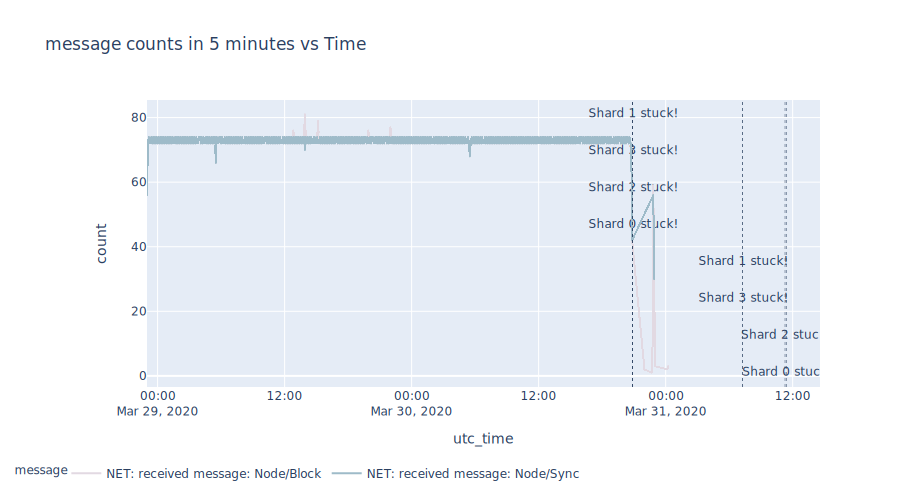

In [10]:
draw_graph(agg, alert, 5)